**Resampling (Data Imbalance)**

In [44]:
# Load the base DataFrame from CSV (without embeddings)
df = pd.read_csv('snowflake_embedding_less_asterisk_cleaned.csv')

# Load the embeddings from the .npy file
embeddings = np.load('multilingual_embeddings.npy')

# Add the embeddings back to the DataFrame
df['MULTILINGUAL_E5LARGE_EMBEDDING'] = list(embeddings)

# Check the type and length of the first embedding to verify
print(type(df['MULTILINGUAL_E5LARGE_EMBEDDING'].iloc[0]), len(df['MULTILINGUAL_E5LARGE_EMBEDDING'].iloc[0]))

<class 'numpy.ndarray'> 1024


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Constants for resampling
upsampling_num = 45000
downsampling_num = 25000

# Extract feature matrix X and target variable Y
X = np.vstack(df['MULTILINGUAL_E5LARGE_EMBEDDING'].values)
Y = df['SIMPLIFIED_CATEGORY'].values

# Encode the labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Calculate class distributions
original_counts = df['SIMPLIFIED_CATEGORY'].value_counts().to_dict()
print("Original class distribution:", original_counts)

# Downsample 'OTHER'
rus = RandomUnderSampler(sampling_strategy={'OTHER': downsampling_num}, random_state=42)
X_res, y_res = rus.fit_resample(X, Y)

# Separate 'OTHER' and other classes
other_indices = [i for i, label in enumerate(y_res) if label == 'OTHER']
minority_indices = [i for i, label in enumerate(y_res) if label != 'OTHER']

X_other, y_other = X_res[other_indices], y_res[other_indices]
X_minority, y_minority = X_res[minority_indices], y_res[minority_indices]

# Scale up other classes using SMOTE
other_classes_counts = {k: v for k, v in original_counts.items() if k != 'OTHER'}
scaling_factor = upsampling_num / sum(other_classes_counts.values())
desired_counts = {label: int(count * scaling_factor) for label, count in other_classes_counts.items()}

# Create SMOTE sampling strategy
smote_strategy = {label: desired_counts[label] for label in Counter(y_minority).keys()}
smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
X_minority_resampled, y_minority_resampled = smote.fit_resample(X_minority, y_minority)

# Combine downsampled 'OTHER' and resampled other classes
X_balanced = np.vstack((X_other, X_minority_resampled))
y_balanced = np.concatenate((y_other, y_minority_resampled))

# Verify class distribution
balanced_counts = Counter(y_balanced)
print("Balanced class distribution:", dict(balanced_counts))

Original class distribution: {'OTHER': 161517, 'password_reset': 8736, 'add_user OR remove_user': 4691, 'os_update': 4648, 'shipping_request': 2676, 'add_user_to_channel OR remove_user_from_channel': 2169, 'add_license OR remove_license': 1668, 'reset_mfa': 1039}
Balanced class distribution: {'OTHER': 25000, 'add_license OR remove_license': 2928, 'add_user OR remove_user': 8237, 'add_user_to_channel OR remove_user_from_channel': 3808, 'os_update': 8161, 'password_reset': 15340, 'reset_mfa': 1824, 'shipping_request': 4698}


**Class Distribution Chart**

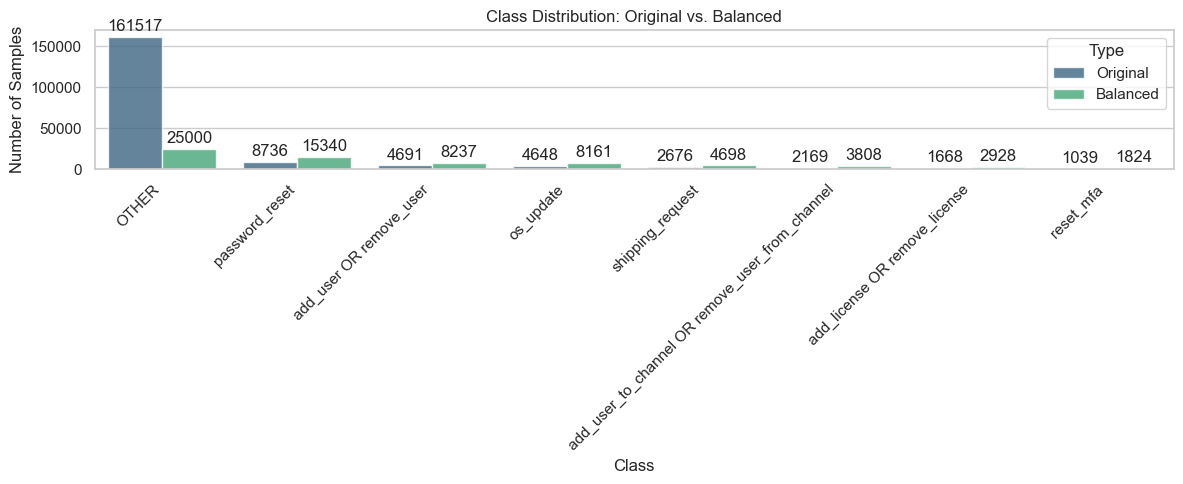

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style for the plots
sns.set_theme(style="whitegrid")

# Function to prepare data for plotting
def prepare_data_for_plot(original_counts, balanced_counts):
    original_df = pd.DataFrame(list(original_counts.items()), columns=['Class', 'Count'])
    original_df['Type'] = 'Original'
    
    balanced_df = pd.DataFrame(list(balanced_counts.items()), columns=['Class', 'Count'])
    balanced_df['Type'] = 'Balanced'
    
    # Combine the two DataFrames
    combined_df = pd.concat([original_df, balanced_df], ignore_index=True)
    return combined_df

# Capture class distributions before and after resampling
counts_before = original_counts  # Use previously calculated original class distribution
counts_after = dict(Counter(y_balanced))  # Calculate balanced class distribution dynamically

# Prepare data for plotting
combined_df = prepare_data_for_plot(counts_before, counts_after)

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(12, 5))
barplot = sns.barplot(
    data=combined_df, 
    x='Class', 
    y='Count', 
    hue='Type', 
    palette='viridis',
    alpha=0.8
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution: Original vs. Balanced')

# Add data labels on top of the bars
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.0f', label_type='edge', padding=2)

plt.tight_layout()
plt.show()